# Lab 09 XOR - Neural Network - Eager Excuetion
* XOR 문제를  Neural Network을 활용해 풀어보도록 하겠습니다.

### 기본 Library 선언 및 Tensorflow 버전 확인
### 이전 ipynb은 Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()
tf.set_random_seed(777)  # for reproducibility

print(tf.__version__)

1.13.1


### 강의에 설명할 Data입니다
* x_data가 2차원 배열이기에 2차원 공간에 표현하여 x1과 x2를 기준으로 y_data 0과 1로 구분하는 예제입니다
* 붉은색과 푸른색으로 0과 1을 표시해 보도록 하겠습니다.

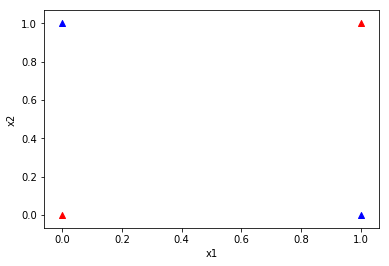

In [2]:
x_data = [[0, 0],
          [0, 1],
          [1, 0],
          [1, 1]]
y_data = [[0],
          [1],
          [1],
          [0]]

plt.scatter(x_data[0][0],x_data[0][1], c='red' , marker='^')
plt.scatter(x_data[3][0],x_data[3][1], c='red' , marker='^')
plt.scatter(x_data[1][0],x_data[1][1], c='blue' , marker='^')
plt.scatter(x_data[2][0],x_data[2][1], c='blue' , marker='^')

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

데이터는 동일

##  Tensorflow Session
### 위 Data를 기준으로 XOR처리를 위한 모델을 만들도록 하겠습니다
* Tensorflow data API를 통해 학습시킬 값들을 담는다 (Batch Size는 한번에 학습시킬 Size로 정한다)
* features,labels는 실재 학습에 쓰일 Data (연산을 위해 Type를 맞춰준다)

In [3]:
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).batch(len(x_data))

def preprocess_data(features, labels):
    features = tf.cast(features, tf.float32)
    labels = tf.cast(labels, tf.float32)
    return features, labels

same preprocess

Neural Network를 통해 XOR해결 
* 위의 Data를 3Layer의 Neural Network를 통해 학습시킨 후 모델을 생성합니다.(강의에서 설명한 구조)

In [4]:
W1 = tf.Variable(tf.random_normal([2, 1]), name='weight1')
b1 = tf.Variable(tf.random_normal([1]), name='bias1')

W2 = tf.Variable(tf.random_normal([2, 1]), name='weight2')
b2 = tf.Variable(tf.random_normal([1]), name='bias2')

W3 = tf.Variable(tf.random_normal([2, 1]), name='weight3')
b3 = tf.Variable(tf.random_normal([1]), name='bias3')

## tf.random_normal([x,y])

x * y 만큼의 random data 생성

Default : mean=0.0, stddev=1.0

In [13]:
print(tf.random_normal([3,10]))

tf.Tensor(
[[ 5.7793218e-01 -1.4722541e-01  1.1743088e+00 -4.7127262e-02
  -1.3825538e+00  1.5664381e+00 -1.4198139e-01 -9.1616791e-01
   1.9199459e-01 -4.0890464e-01]
 [-7.1848673e-01 -9.6025683e-02 -1.4669256e+00 -6.5649629e-01
   2.3324170e+00  2.8007230e-01 -6.9065511e-02  9.4847208e-01
   4.4397029e-01 -4.4364649e-01]
 [-2.8160429e-01  1.4413358e+00  4.7952574e-01  1.0627917e+00
  -2.3727018e-01 -2.2720157e-03  1.8762326e+00 -3.4690374e-01
  -1.4689597e-01  8.6908734e-01]], shape=(3, 10), dtype=float32)


In [19]:
def neural_net(features):
    layer1 = tf.sigmoid(tf.matmul(features, W1) + b1)
    layer2 = tf.sigmoid(tf.matmul(features, W2) + b2)
    layer3 = tf.concat([layer1, layer2],-1)
    layer3 = tf.reshape(layer3, shape = [-1,2])
    hypothesis = tf.sigmoid(tf.matmul(layer3, W3) + b3)
    return hypothesis

# hypothesis vs label
def loss_fn(hypothesis, labels):
    cost = -tf.reduce_mean(labels * tf.log(hypothesis) + (1 - labels) * tf.log(1 - hypothesis))
    return cost

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.float32))
    return accuracy

def grad(hypothesis, features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(neural_net(features),labels)
    return tape.gradient(loss_value, [W1, W2, W3, b1, b2, b3])

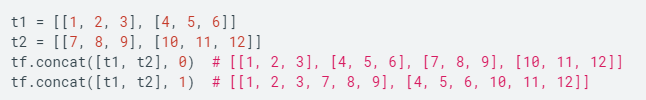

In [18]:
t1 = [[1, 2, 3], [4, 5, 6]]
t2 = [[7, 8, 9], [10, 11, 12]]
print(tf.concat([t1, t2], -1)) # [[1, 2, 3, 7, 8, 9], [4, 5, 6, 10, 11, 12]]
print(tf.concat([t1, t2], 1))  # [[1, 2, 3, 7, 8, 9], [4, 5, 6, 10, 11, 12]]

tf.Tensor(
[[ 1  2  3  7  8  9]
 [ 4  5  6 10 11 12]], shape=(2, 6), dtype=int32)
tf.Tensor(
[[ 1  2  3  7  8  9]
 [ 4  5  6 10 11 12]], shape=(2, 6), dtype=int32)


In [6]:
EPOCHS = 50000

for step in range(EPOCHS):
    for features, labels  in tfe.Iterator(dataset):
        features, labels = preprocess_data(features, labels)
        grads = grad(neural_net(features), features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W1, W2, W3, b1, b2, b3]))
        if step % 5000 == 0:
            print("Iter: {}, Loss: {:.4f}".format(step, loss_fn(neural_net(features),labels)))
x_data, y_data = preprocess_data(x_data, y_data)
test_acc = accuracy_fn(neural_net(x_data),y_data)
print("Testset Accuracy: {:.4f}".format(test_acc))

Instructions for updating:
Colocations handled automatically by placer.
Iter: 0, Loss: 0.8487
Iter: 5000, Loss: 0.6847
Iter: 10000, Loss: 0.6610
Iter: 15000, Loss: 0.6154
Iter: 20000, Loss: 0.5722
Iter: 25000, Loss: 0.5433
Iter: 30000, Loss: 0.5211
Iter: 35000, Loss: 0.4911
Iter: 40000, Loss: 0.4416
Iter: 45000, Loss: 0.3313
Testset Accuracy: 1.0000


epoch 차이도 좀 있지만, Logistic Regression에 비해

Accuracy 0.5 --> 1.0 
Loss     0.69 -> 0.33

개선됨